In [1]:
import os
import sys
sys.path.append("../")
                
import pandas as pd
import numpy as np
import glob

import pickle
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy
from utils._bootstrap import bootstrap, CONF
import sympy

In [2]:
def combine(equation, var_or_mse):
    meta_reg = os.path.join(equation,var_or_mse,'*.p')
    meta_files = glob.glob(meta_reg)
    csv_files = [file.split('_meta.p')[0]+'_table.csv' for file in meta_files]
    dfs = []
    for meta_file, csv_file in zip(meta_files,csv_files):
        df = pd.read_csv(csv_file)
        with open(meta_file, 'rb') as f:
            setting = pickle.load(f)
            args = setting['arguments']
            gp_config = setting['gp_config']
            df['name'] = args.name
            df['equation_number'] = args.equation_number
            df['width'] = args.width
            df['frequency_per_dim'] = args.frequency_per_dim
            df['noise_ratio'] = args.noise_ratio

            if var_or_mse == 'var':
                df['full_grid_samples'] = args.full_grid_samples
                df['max_ind_basis'] = args.max_ind_basis
                df['basis'] = args.basis
            elif var_or_mse == 'mse':
                df['diff_engine'] = args.diff_engine

            df['conditions_set'] = args.conditions_set
            df['num_trials'] = args.num_trials
            df['normalization'] = args.normalization
            df['solver'] = args.solver
            df['global_seed'] = args.seed
            df['num_samples'] = args.num_samples
            df['source'] = setting['table']
            for key in gp_config.keys():
                if key not in ['function_set']:
                    df[key] = gp_config[key]
        dfs.append(df)    
    full_df = pd.concat(dfs,ignore_index=True)
    full_df.drop(columns=['Unnamed: 0'],inplace=True)
    return full_df

In [3]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
linewidth = 2.0
markersize = 10.0
    
def plot_operator_difference_bootstrap(ax,df,conf,noise_ratios):
    
    algs = ['var','pde_find_srr','pde_find_frols','weak_sindy_srr','weak_sindy_frols']
    colors = ['#377eb8','#a65628', '#984ea3', '#999999', '#e41a1c']
    names = ['D-CIPHER', 'PDE-FIND (S)', 'PDE-FIND (F)', 'WSINDy (S)', 'WSINDy (F)']
    for alg, color, name in zip(algs,colors,names):
        
        ints = [bootstrap(df.loc[df['noise_ratio'] == noise_ratio,f"{alg}_error"].to_numpy(float).reshape(1,-1),np.mean,vectorized=True,confidence_level=conf).confidence_interval for noise_ratio in noise_ratios]
        stds = [bootstrap(df.loc[df['noise_ratio'] == noise_ratio,f"{alg}_error"].to_numpy(float).reshape(1,-1),np.mean,vectorized=True,confidence_level=conf).standard_error for noise_ratio in noise_ratios]

        lows = [i.low for i in ints]
        highs = [i.high for i in ints]

        means = df.groupby('noise_ratio')[f"{alg}_error"].mean()
        ax.plot(noise_ratios,means.loc[noise_ratios],'o-',label=name,color=color,markersize=markersize,linewidth=linewidth)
        ax.fill_between(noise_ratios,lows,highs,alpha=0.3,color=color)

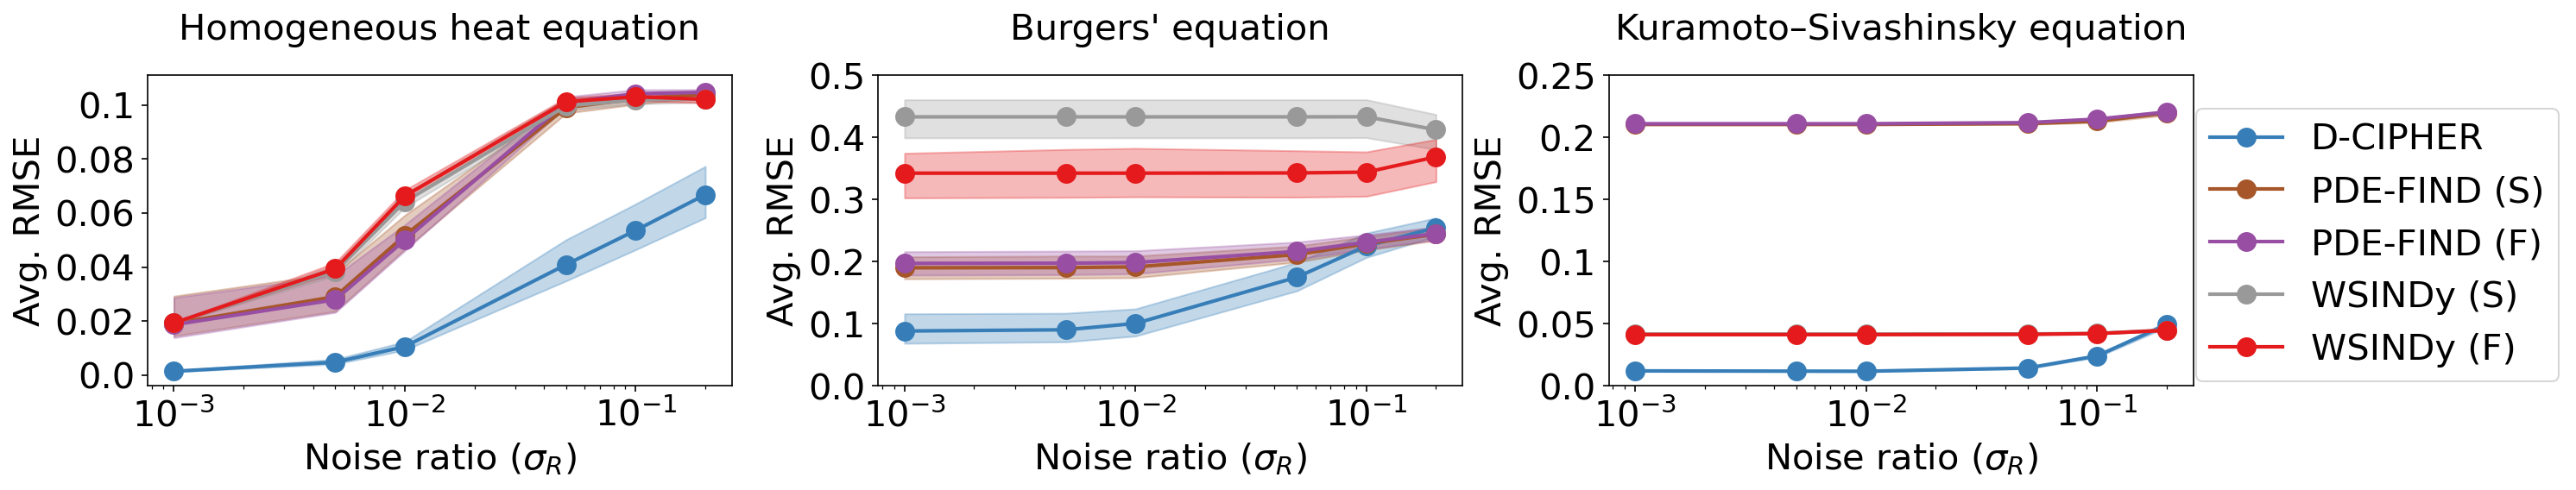

In [4]:
xlabel_fontsize = 20
ylabel_fontsize = 20
title_fontsize = 20
legend_fontsize = 20
ticks_fontsize = 20

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3,figsize=(20,4),dpi=150)


# Heat equation
heat_df = combine("../results/HeatHomogeneous",'all')
plot_operator_difference_bootstrap(ax1,heat_df,CONF,[0.001,0.005,0.01,0.05,0.1,0.2])
ax1.set_xscale('log')
ax1.set_xlabel(r'Noise ratio ($\sigma_R$)', fontsize=xlabel_fontsize)
ax1.set_ylabel('Avg. RMSE', fontsize=ylabel_fontsize)
ax1.set_xticks([0.001,0.01,0.1])
ax1.set_xticklabels(['$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$'], fontsize=ticks_fontsize)
ax1.set_yticks([0.00,0.02,0.04,0.06,0.08,0.10])
ax1.set_yticklabels([0.00,0.02,0.04,0.06,0.08,0.10], fontsize=ticks_fontsize)
ax1.set_title("Homogeneous heat equation", fontsize=title_fontsize, pad=20)

# Burgers' equation
burger_df = combine("../results/Burger",'all')
plot_operator_difference_bootstrap(ax2,burger_df,CONF,[0.001,0.005,0.01,0.05,0.1,0.2])
ax2.set_xscale('log')
ax2.set_xlabel(r'Noise ratio ($\sigma_R$)', fontsize=xlabel_fontsize)
ax2.set_ylabel('Avg. RMSE', fontsize=ylabel_fontsize)
ax2.set_xticks([0.001,0.01,0.1])
ax2.set_xticklabels(['$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$'], fontsize=ticks_fontsize)
ax2.set_yticks([0.00,0.1,0.2,0.3,0.4,0.5])
ax2.set_yticklabels([0.00,0.1,0.2,0.3,0.4,0.5], fontsize=ticks_fontsize)
ax2.set_title("Burgers' equation", fontsize=title_fontsize, pad=20)

# Kuramoto–Sivashinsky equation
ks_df = combine("../results/KS",'all')
plot_operator_difference_bootstrap(ax3,ks_df,CONF,[0.001,0.005,0.01,0.05,0.1,0.2])
ax3.set_xscale('log')
ax3.set_xlabel(r'Noise ratio ($\sigma_R$)', fontsize=xlabel_fontsize)
ax3.set_ylabel('Avg. RMSE', fontsize=ylabel_fontsize)
ax3.set_xticks([0.001,0.01,0.1])
ax3.set_xticklabels(['$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$'], fontsize=ticks_fontsize)
ax3.set_yticks([0.00,0.05,0.1,0.15,0.2,0.25])
ax3.set_yticklabels([0.00,0.05,0.1,0.15,0.2,0.25], fontsize=ticks_fontsize)
ax3.set_title("Kuramoto–Sivashinsky equation", fontsize=title_fontsize, pad=20)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels,loc='center right',fontsize=legend_fontsize)

plt.subplots_adjust(left=0.06,
                    bottom=0.20, 
                    right=0.85, 
                    top=0.8, 
                    wspace=0.25, 
                    hspace=0.4)

plt.savefig("figures/Figure_3.svg",dpi=fig.dpi)
plt.show()